In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold

In [2]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/test_data_.csv')

# Remove rows where 'BDSPPatientID' is 122501769
df = df[df['BDSPPatientID'] != 122501769]

# Save the DataFrame back to a CSV file
df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/test_data_.csv', index=False)


In [3]:
# load testing set

#Detecting ACTIVE SDH not just sdh. Pretty great results. 

matrix = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/test_data_.csv')
matrix = matrix.sample(random_state = 2023, frac = 1, ignore_index=True)  # shuffle
# Drop the 'annot' column to create X_data
X_data = matrix.drop('annot', axis=1).reset_index(drop = True)

# Extract the 'BDSPPatientID' and 'annot' columns to create y_data_pre
y_data_pre = matrix[['BDSPPatientID', 'annot']].reset_index(drop = True)

assert len(X_data) == len(y_data_pre), "DataFrames must have the same length"
X_data['annot']=y_data_pre['annot']
print(X_data)

y_data = X_data[['BDSPPatientID', 'annot']]
print(y_data)
y_data_pre=y_data
print(y_data_pre)
y_holdout = y_data_pre['annot']
print(y_holdout)

X_data=X_data.drop(['annot'], axis=1)
X_holdout=X_data.drop(['BDSPPatientID', 'ContactDate', 'hospital', 'Unnamed: 0', 'NoteFileName', 'Site'], axis=1) 
print(X_holdout)
feature_names = X_holdout.columns.tolist()

      Unnamed: 0  BDSPPatientID ContactDate  \
0           1451      116551953  2017-04-12   
1           1625      150626794  2016-06-28   
2            921      111708750  2020-07-01   
3           2827      150293166  2013-11-24   
4           2675      150744963  2011-09-26   
...          ...            ...         ...   
1494        1806      150001850  2014-07-26   
1495        1048      115875112  2016-11-04   
1496        1406      115098587  2021-07-12   
1497         927      117157833  2021-03-29   
1498        1731      151195673  2015-04-27   

                                   NoteFileName   Site  CT  MRI  acut sdh_pos  \
0     Notes_13364499668_1918544682_20170412.txt    MGB   1    1             0   
1      Notes_1130485717_9766596953_20160628.txt  BIDMC   1    0             0   
2     Notes_13504793443_3523347700_20200701.txt    MGB   0    0             0   
3       Notes_1130151802_169903067_20131124.txt  BIDMC   0    0             0   
4      Notes_1130603513_143940

Accuracy: 0.9293 (95% CI: 0.9306 - 0.9540)
Precision: 0.7825 (95% CI: 0.8078 - 0.8760)
Recall (Sensitivity): 0.9594 (95% CI: 0.8977 - 0.9511)
F1 Score: 0.8620
AUC (ROC): 0.9773 (95% CI: 0.9704 - 0.9832)
AUC (PR): 0.9021 (95% CI: 0.8616 - 0.9344)
Specificity: 0.9203
False Positives: 92
False Negatives: 14


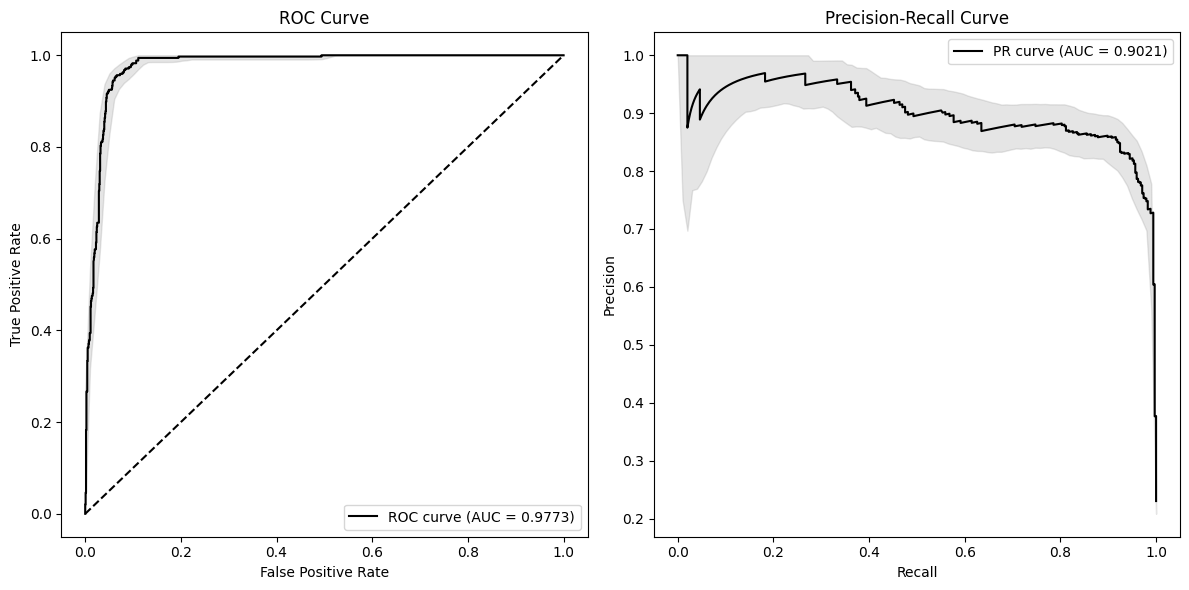

Number of False Positive Patient IDs: 92
Number of False Negative Patient IDs: 14


In [10]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score, f1_score, precision_score, recall_score,
    precision_recall_curve, auc, confusion_matrix, accuracy_score
)
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression

# Function to compute confidence intervals using bootstrapping
def bootstrap_ci(y_true, y_pred_proba, metric_func, num_bootstrap=1000, alpha=0.05):
    stats = []
    for _ in range(num_bootstrap):
        indices = resample(np.arange(len(y_true)), replace=True)
        y_true_bs = y_true[indices]
        y_pred_proba_bs = y_pred_proba[indices]
        stat = metric_func(y_true_bs, y_pred_proba_bs)
        stats.append(stat)
    lower_bound = np.percentile(stats, 100 * alpha / 2)
    upper_bound = np.percentile(stats, 100 * (1 - alpha / 2))
    return lower_bound, upper_bound

# Load models and cutoffs
models = []
cutoffs = []
feature_importances_dict = {}

for fold in range(10):
    with open(f'model_train_allhospitals_Notes+ICD+Med_fold{fold+1}.pickle', 'rb') as f:
        res = pickle.load(f)
    models.append(res['model'])
    cutoffs.append(res['cutoff'])
    
    # Extract feature importances if available
    model = res['model']
    if hasattr(model, 'feature_importances_'):
        feature_importances_dict[fold] = model.feature_importances_

# Predict on holdout set
y_pred_proba = np.zeros(X_holdout.shape[0])
y_pred = np.zeros(X_holdout.shape[0])

for model, cutoff in zip(models, cutoffs):
    yp_proba = model.predict_proba(X_holdout)[:, 1]
    y_pred_proba += yp_proba
    y_pred += (yp_proba > cutoff).astype(int)

# Average probability and majority vote
y_pred_proba /= len(models)
y_pred = (y_pred > (len(models) / 2)).astype(int)

# Calculate metrics
fpr, tpr, _ = roc_curve(y_holdout, y_pred_proba)
auc_roc = roc_auc_score(y_holdout, y_pred_proba)
f1_holdout = f1_score(y_holdout, y_pred)
precision_holdout = precision_score(y_holdout, y_pred)
recall_holdout = recall_score(y_holdout, y_pred)
precision, recall, _ = precision_recall_curve(y_holdout, y_pred_proba)
auc_pr = auc(recall, precision)
accuracy = accuracy_score(y_holdout, y_pred)
cf_holdout = confusion_matrix(y_holdout, y_pred)

# Extract false positives, false negatives, true positives, and true negatives
tn, fp, fn, tp = cf_holdout.ravel()

# Calculate specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Compute confidence intervals
accuracy_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: accuracy_score(y, (p > 0.5).astype(int)))
precision_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: precision_score(y, (p > 0.5).astype(int)))
recall_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: recall_score(y, (p > 0.5).astype(int)))
auc_roc_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: roc_auc_score(y, p))
auc_pr_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: auc(precision_recall_curve(y, p)[1], precision_recall_curve(y, p)[0]))

# Print metrics
print(f"Accuracy: {accuracy:.4f} (95% CI: {accuracy_ci[0]:.4f} - {accuracy_ci[1]:.4f})")
print(f"Precision: {precision_holdout:.4f} (95% CI: {precision_ci[0]:.4f} - {precision_ci[1]:.4f})")
print(f"Recall (Sensitivity): {recall_holdout:.4f} (95% CI: {recall_ci[0]:.4f} - {recall_ci[1]:.4f})")
print(f"F1 Score: {f1_holdout:.4f}")
print(f"AUC (ROC): {auc_roc:.4f} (95% CI: {auc_roc_ci[0]:.4f} - {auc_roc_ci[1]:.4f})")
print(f"AUC (PR): {auc_pr:.4f} (95% CI: {auc_pr_ci[0]:.4f} - {auc_pr_ci[1]:.4f})")
print(f"Specificity: {specificity:.4f}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

# Plot ROC Curve with Confidence Intervals
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
main_fpr, main_tpr, _ = roc_curve(y_holdout, y_pred_proba)
main_auc = auc(main_fpr, main_tpr)

# Calculate confidence intervals for ROC
roc_fpr_interp = np.linspace(0, 1, 100)
roc_tpr_interp = [np.interp(roc_fpr_interp, fpr, tpr) for fpr, tpr in roc_curves_bootstrap]
roc_mean_tpr = np.mean(roc_tpr_interp, axis=0)
roc_lower_tpr = np.percentile(roc_tpr_interp, 2.5, axis=0)
roc_upper_tpr = np.percentile(roc_tpr_interp, 97.5, axis=0)

plt.plot(main_fpr, main_tpr, color='black', label=f'ROC curve (AUC = {main_auc:.4f})')
plt.fill_between(roc_fpr_interp, roc_lower_tpr, roc_upper_tpr, color='grey', alpha=0.2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Plot Precision-Recall Curve with Confidence Intervals
plt.subplot(1, 2, 2)
main_precision, main_recall, _ = precision_recall_curve(y_holdout, y_pred_proba)
main_auc_pr = auc(main_recall, main_precision)

# Calculate confidence intervals for PR
pr_recall_interp = np.linspace(0, 1, 100)
pr_precision_interp = [np.interp(pr_recall_interp, recall[::-1], precision[::-1]) for precision, recall in pr_curves_bootstrap]
pr_mean_precision = np.mean(pr_precision_interp, axis=0)
pr_lower_precision = np.percentile(pr_precision_interp, 2.5, axis=0)
pr_upper_precision = np.percentile(pr_precision_interp, 97.5, axis=0)

plt.plot(main_recall, main_precision, color='black', label=f'PR curve (AUC = {main_auc_pr:.4f})')
plt.fill_between(pr_recall_interp, pr_lower_precision, pr_upper_precision, color='grey', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Extract patient IDs for false positives and false negatives
# Ensure that the index of the DataFrame is properly aligned
# Assuming matrix.BDSPPatientID is a pandas Series with correct alignment
false_positive_ids = matrix.BDSPPatientID[(y_holdout == 0) & (y_pred == 1)]
false_negative_ids = matrix.BDSPPatientID[(y_holdout == 1) & (y_pred == 0)]

# Create DataFrames with patient IDs, annot (y_holdout), and y_pred
false_positive_df = pd.DataFrame({
    'BDSPPatientID': false_positive_ids,
    'annot': y_holdout[(y_holdout == 0) & (y_pred == 1)],
    'y_pred': y_pred[(y_holdout == 0) & (y_pred == 1)]
})

false_negative_df = pd.DataFrame({
    'BDSPPatientID': false_negative_ids,
    'annot': y_holdout[(y_holdout == 1) & (y_pred == 0)],
    'y_pred': y_pred[(y_holdout == 1) & (y_pred == 0)]
})

# Print the number of false positive and false negative patient IDs
print(f"Number of False Positive Patient IDs: {len(false_positive_df)}")
print(f"Number of False Negative Patient IDs: {len(false_negative_df)}")

# Save to CSV files
# false_positive_df.to_csv("false_positive_ids.csv", index=False)
# false_negative_df.to_csv("false_negative_ids.csv", index=False)


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as pd

def bootstrap_resample(y_true, y_pred_proba, y_pred, n_iterations=1000, alpha=0.95):
    aucs = []
    f1s = []
    precisions = []
    recalls = []
    accuracies = []
    specificities = []
    auc_prs = []
    roc_curves = []
    pr_curves = []
    n_size = len(y_true)
    for _ in range(n_iterations):
        indices = np.random.randint(0, n_size, n_size)
        if len(np.unique(y_true[indices])) < 2:
            continue  # skip this resample if it does not have both classes
        y_true_resampled = y_true[indices]
        y_pred_proba_resampled = y_pred_proba[indices]
        y_pred_resampled = y_pred[indices]

        # Calculate metrics
        aucs.append(roc_auc_score(y_true_resampled, y_pred_proba_resampled))
        f1s.append(f1_score(y_true_resampled, y_pred_resampled))
        precisions.append(precision_score(y_true_resampled, y_pred_resampled))
        recalls.append(recall_score(y_true_resampled, y_pred_resampled))
        accuracies.append(accuracy_score(y_true_resampled, y_pred_resampled))
        
        # Compute specificity
        tn, fp, fn, tp = confusion_matrix(y_true_resampled, y_pred_resampled).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
        
        # Compute AUC-PR
        precision, recall, _ = precision_recall_curve(y_true_resampled, y_pred_proba_resampled)
        auc_prs.append(auc(recall, precision))
        
        # Compute ROC and PR curves
        fpr, tpr, _ = roc_curve(y_true_resampled, y_pred_proba_resampled)
        roc_curves.append((fpr, tpr))
        pr_curves.append((precision, recall))
    
    # Calculate confidence intervals
    lower_p = ((1.0 - alpha) / 2.0) * 100
    upper_p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    auc_ci = np.percentile(aucs, [lower_p, upper_p])
    f1_ci = np.percentile(f1s, [lower_p, upper_p])
    precision_ci = np.percentile(precisions, [lower_p, upper_p])
    recall_ci = np.percentile(recalls, [lower_p, upper_p])
    accuracy_ci = np.percentile(accuracies, [lower_p, upper_p])
    specificity_ci = np.percentile(specificities, [lower_p, upper_p])
    auc_pr_ci = np.percentile(auc_prs, [lower_p, upper_p])
    
    return auc_ci, f1_ci, precision_ci, recall_ci, accuracy_ci, specificity_ci, auc_pr_ci, roc_curves, pr_curves

# Perform bootstrap resampling to get confidence intervals
auc_ci, f1_ci, precision_ci, recall_ci, accuracy_ci, specificity_ci, auc_pr_ci, roc_curves_bootstrap, pr_curves_bootstrap = bootstrap_resample(y_holdout, y_pred_proba, y_pred)

# Calculate metrics on holdout set
auc_roc = roc_auc_score(y_holdout, y_pred_proba)
f1_holdout = f1_score(y_holdout, y_pred)
precision_holdout = precision_score(y_holdout, y_pred)
recall_holdout = recall_score(y_holdout, y_pred)
accuracy = accuracy_score(y_holdout, y_pred)
tn, fp, fn, tp = confusion_matrix(y_holdout, y_pred).ravel()
specificity_holdout = tn / (tn + fp) if (tn + fp) > 0 else 0
precision, recall, _ = precision_recall_curve(y_holdout, y_pred_proba)
auc_pr = auc(recall, precision)

# Print metrics and confidence intervals
print("Metrics on Holdout Set:")
print(f"AUC_Roc: {auc_roc:.4f} (95% CI: {auc_ci[0]:.4f} - {auc_ci[1]:.4f})")
print(f"F1 Score: {f1_holdout:.4f} (95% CI: {f1_ci[0]:.4f} - {f1_ci[1]:.4f})")
print(f"Precision: {precision_holdout:.4f} (95% CI: {precision_ci[0]:.4f} - {precision_ci[1]:.4f})")
print(f"Recall: {recall_holdout:.4f} (95% CI: {recall_ci[0]:.4f} - {recall_ci[1]:.4f})")
print(f"Accuracy: {accuracy:.4f} (95% CI: {accuracy_ci[0]:.4f} - {accuracy_ci[1]:.4f})")
print(f"Specificity: {specificity_holdout:.4f} (95% CI: {specificity_ci[0]:.4f} - {specificity_ci[1]:.4f})")
print(f"AUC_PR: {auc_pr:.4f} (95% CI: {auc_pr_ci[0]:.4f} - {auc_pr_ci[1]:.4f})")

# Calculate confidence intervals for ROC
roc_fpr_interp = np.linspace(0, 1, 100)
roc_tpr_interp = [np.interp(roc_fpr_interp, fpr, tpr) for fpr, tpr in roc_curves_bootstrap]
roc_mean_tpr = np.mean(roc_tpr_interp, axis=0)
roc_lower_tpr = np.percentile(roc_tpr_interp, 2.5, axis=0)
roc_upper_tpr = np.percentile(roc_tpr_interp, 97.5, axis=0)

# Calculate confidence intervals for PR
pr_recall_interp = np.linspace(0, 1, 100)
pr_precision_interp = [np.interp(pr_recall_interp, recall[::-1], precision[::-1]) for precision, recall in pr_curves_bootstrap]
pr_mean_precision = np.mean(pr_precision_interp, axis=0)
pr_lower_precision = np.percentile(pr_precision_interp, 2.5, axis=0)
pr_upper_precision = np.percentile(pr_precision_interp, 97.5, axis=0)

# Plot ROC curve with confidence intervals
plt.figure(figsize=(6, 6))
main_fpr, main_tpr, _ = roc_curve(y_holdout, y_pred_proba)
main_auc = auc(main_fpr, main_tpr)
plt.plot(main_fpr, main_tpr, color='black')  # Change line color to black
plt.fill_between(roc_fpr_interp, roc_lower_tpr, roc_upper_tpr, color='grey', alpha=0.2)
plt.plot([0, 1], [0, 1], 'k--')
plt.text(0.99, 0.01, f"AUROC: {auc_roc:.3f} (95% CI: {auc_ci[0]:.3f} - {auc_ci[1]:.3f})", ha='right', va='bottom', fontsize=14)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axis('equal')
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.savefig('LR_AUC_holdout.png')
plt.show()

# Plot PR curve with confidence intervals
plt.figure(figsize=(6, 6))
main_precision, main_recall, _ = precision_recall_curve(y_holdout, y_pred_proba)
main_auc_pr = auc(main_recall, main_precision)
plt.plot(main_recall, main_precision, color='black')  # Change line color to black
plt.fill_between(pr_recall_interp, pr_lower_precision, pr_upper_precision, color='grey', alpha=0.2)
plt.text(0.99, 0.01, f"AUPRC: {auc_pr:.3f} (95% CI: {auc_pr_ci[0]:.3f} - {auc_pr_ci[1]:.3f})", ha='right', va='bottom', fontsize=14)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axis('equal')
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.savefig('LR_PR_holdout.png')
plt.show()

# Save all the data
df_holdout = pd.DataFrame({
    'metric': ['auc', 'f1', 'precision', 'recall', 'accuracy', 'specificity', 'auc_pr'],
    'value': [auc_roc, f1_holdout, precision_holdout, recall_holdout, accuracy, specificity_holdout, auc_pr],
    'ci_lower': [auc_ci[0], f1_ci[0], precision_ci[0], recall_ci[0], accuracy_ci[0], specificity_ci[0], auc_pr_ci[0]],
    'ci_upper': [auc_ci[1], f1_ci[1], precision_ci[1], recall_ci[1], accuracy_ci[1], specificity_ci[1], auc_pr_ci[1]]
})
df_holdout.to_csv('LR_RC_CI_holdout_metrics.csv', index = False)


Confusion Matrix:
[[1062   92]
 [  14  331]]
True Negatives (TN): 1062
False Positives (FP): 92
False Negatives (FN): 14
True Positives (TP): 331
Specificity: 0.9203
False Positives: 92
False Negatives: 14


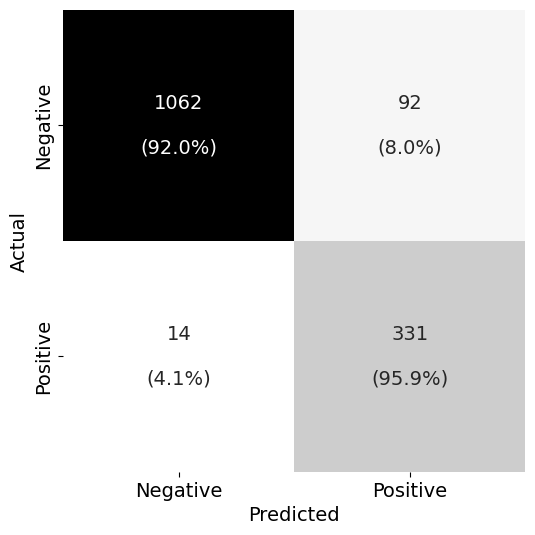

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute confusion matrix
cf_holdout = confusion_matrix(y_holdout, y_pred)

# Extract false positives, false negatives, true positives, and true negatives
tn, fp, fn, tp = cf_holdout.ravel()

# Calculate specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Print confusion matrix and metrics
print("Confusion Matrix:")
print(cf_holdout)
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"Specificity: {specificity:.4f}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

cf_holdout_perc = cf_holdout / cf_holdout.sum(axis=1, keepdims=True) * 100
cf_hold_display = np.empty_like(cf_holdout, dtype=object)
for i in range(cf_holdout.shape[0]):
    for j in range(cf_holdout.shape[1]):
        cf_hold_display[i, j] = f'{cf_holdout[i, j]}\n\n({cf_holdout_perc[i, j]:.1f}%)'

# Plot confusion matrix
plt.figure(figsize=(6, 6))
ax = sns.heatmap(cf_holdout, annot=cf_hold_display, fmt='s', cmap='Greys', 
                 xticklabels=['Negative', 'Positive'], 
                 yticklabels=['Negative', 'Positive'],
                 cbar=False, square=True)  # Hide color bar for a cleaner look

# Set font size for all text elements
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

# Ensure all annotations have font size 14
for text in ax.texts:
    text.set_fontsize(14)

plt.show()